<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/PDSH-cover-small.png?raw=1">

*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

<!--NAVIGATION-->
< [Computation on Arrays: Broadcasting](02.05-Computation-on-arrays-broadcasting.ipynb) | [Contents](Index.ipynb) | [Fancy Indexing](02.07-Fancy-Indexing.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/02.06-Boolean-Arrays-and-Masks.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


# 比較、遮罩以及布林邏輯

本章節重點在使用布林遮罩對於Numpy陣列中值進行檢驗與操作。

遮罩:根據某些條件，對於陣列中的值進行擷取、修改、計數或是其他操作時使用。例如: 想要計算所有大於某一條件的所有元素個數，或是要移除所有超過某一個臨界值的異常值等等。

在Numpy中，使用布林遮罩來完成這一類型的工作，會比較有效率。

## Example: 計算下雨天數


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

# 利用Pandas去取得雨量(英吋數)放在Numpy陣列中
rainfall = pd.read_csv('data/Seattle2014.csv')['PRCP'].values
inches = rainfall / 254.0  # 1/10mm -> inches
inches.shape

(365,)

共包含了365筆數值，以英吋為單位儲存從1/1到12/31每日的降雨量

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # 設定繪圖的樣式

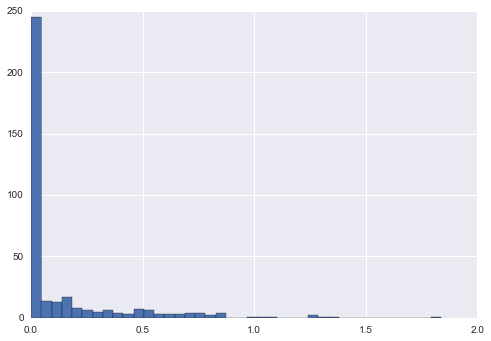

In [ ]:
plt.hist(inches, 40);

圖片告訴我們，在2014年大多數天數的降雨量都是趨近於0，但這張圖就無法告訴我們更多事情。

例如:這一年有多少個下雨天?那些下雨天的平均降雨量是多少?有多少天的降雨量是超過半英吋的?

### 深入挖掘資料

可以用幾個方法:
1. 用迴圈檢視這些資料 (效率差)
2. Numpy的ufuncs在陣列上進行迴圈運算，快速執行以元素操作為單位的算術運算
3. Numpy的遮罩

## 當做是ufuncs的比較運算子

在前面介紹ufuncs時，特別聚焦在``+``, ``-``, ``*``, ``/``和其他在陣列以元素為操作單位可以用的運算子。
NumPy也可以使用比較運算子像是`<`(小於)以及`>`(大於)當作元素操作的ufuncs。

比較運算子的結果大多是一個布林值資料型態的陣列，所有可以用的6個標準比較運算子如下:

In [ ]:
x = np.array([1, 2, 3, 4, 5])

In [ ]:
x < 3  # 小於

array([ True,  True, False, False, False], dtype=bool)

In [ ]:
x > 3  # 大於

array([False, False, False,  True,  True], dtype=bool)

In [ ]:
x <= 3  # 小於等於

array([ True,  True,  True, False, False], dtype=bool)

In [ ]:
x >= 3  # 大於等於

array([False, False,  True,  True,  True], dtype=bool)

In [ ]:
x != 3  # 不等於

array([ True,  True, False,  True,  True], dtype=bool)

In [ ]:
x == 3  # 等於(記得是2個等號)

array([False, False,  True, False, False], dtype=bool)

也可以逐元素的比較2個陣列，而且可以包含複合的敘述

In [ ]:
(2 * x) == (x ** 2)

array([False,  True, False, False, False], dtype=bool)

比較運算子被當作是Numpy中的ufuncs。例如:當你寫x<3，Numpy內部使用的是`np.less(x, 3)`.
    
以下是比較運算子和它們相對應ufunc的摘要:

| Operator	    | Equivalent ufunc    || Operator	   | Equivalent ufunc    |
|---------------|---------------------||---------------|---------------------|
|``==``         |``np.equal``         ||``!=``         |``np.not_equal``     |
|``<``          |``np.less``          ||``<=``         |``np.less_equal``    |
|``>``          |``np.greater``       ||``>=``         |``np.greater_equal`` |

就像是算術ufuncs的例子中一樣，它們可以在任何大小和形狀的陣列中使用。

底下是一個二維陣列的例子:

In [ ]:
rng = np.random.RandomState(0)
x = rng.randint(10, size=(3, 4))
x

array([[5, 0, 3, 3],
       [7, 9, 3, 5],
       [2, 4, 7, 6]])

In [ ]:
x < 6

array([[ True,  True,  True,  True],
       [False, False,  True,  True],
       [ True,  True, False, False]], dtype=bool)

在上面的例子中，其結果都是布林值陣列，而Numpy提供了幾個樣式用來使用這些布林值的結果。

## 使用布林陣列

可以針對任一布林陣列，做非常多有用的運算。

In [ ]:
print(x)

[[5 0 3 3]
 [7 9 3 5]
 [2 4 7 6]]


### 計算項目數量

要計算在一個布林陣列中有多少個`True`，`np.count_nonzero`就很有用:

In [ ]:
# 小於6的值有多少個?
np.count_nonzero(x < 6)

8

也可以使用`np.sum`，在這個例子`False`被當作是`0`，`True`被當作是`1`

In [ ]:
np.sum(x < 6)

8

使用`sum()`的好處是，加總計算可以沿著欄或列進行(跟其他Numpy聚合函式一樣)

In [ ]:
# 每一列中有多少個數值小於6?
np.sum(x < 6, axis=1)

array([4, 2, 2])

如果對於快速檢查所有值或任一值是否為真值感興趣，可以使用`np.any`或 `np.all`

In [ ]:
# 是否有任一個值大於8?
np.any(x > 8)

True

In [ ]:
# 是否有任一個值小於0?
np.any(x < 0)

False

In [ ]:
# 所有的值都小於10嗎?
np.all(x < 10)

True

In [ ]:
# 所有的值都等於6嗎?
np.all(x == 6)

False

``np.all`` 和 ``np.any`` 可以被使用在任何指定的維度軸上，例如:

In [ ]:
# 每一維度軸中所有的值都小於8嗎?
np.all(x < 8, axis=1)

array([ True, False,  True], dtype=bool)

### 布林運算子

若想要篩選多個條件的結果，可以透過Python的*位元邏輯運算子*,`&`, `|`, `^`, 以及 `~`。
就像是標準的算數運算子，Numpy使用ufuncs重載、overload了這些運算子，讓它們可以運行在陣列(通常是布林值)元素上。


In [ ]:
# 雨量介於0.5和1.0英吋之間的天數
np.sum((inches > 0.5) & (inches < 1))

29

括號在這裡很重要，因為運算子的優先順序規則，如果移除括號，就會像是以下的方式計算，會導致錯誤:

``` python
inches > (0.5 & inches) < 1
```



以下的表格列出了位元布林運算子和其相對應的ufuncs供參考:

| Operator	    | Equivalent ufunc    || Operator	    | Equivalent ufunc    |
|---------------|---------------------||---------------|---------------------|
|``&``          |``np.bitwise_and``   ||&#124;         |``np.bitwise_or``    |
|``^``          |``np.bitwise_xor``   ||``~``          |``np.bitwise_not``   |

有了這些工具，就可以回答之前關於天氣資料中，曾經提到過的問題。

In [ ]:
print("沒有下雨的天數:      ", np.sum(inches == 0))
print("下雨的天數:         ", np.sum(inches != 0))
print("雨量超過0.5英吋的天數:", np.sum(inches > 0.5))
print("雨量小於0.1英吋的下雨天數:", np.sum((inches > 0) &
                                                (inches < 0.2)))

Number days without rain:       215
Number days with rain:          150
Days with more than 0.5 inches: 37
Rainy days with < 0.2 inches  : 75


## 布林陣列當作遮罩

使用更強大的方法: 用布林陣列當作是遮罩，去選取資料中特定的子集合。

假設要在`x`陣列中，找出一個所有值都小於5個陣列:

In [ ]:
x

array([[5, 0, 3, 3],
       [7, 9, 3, 5],
       [2, 4, 7, 6]])

就像是先前看過的，可以快速使用這個條件獲得布林陣列:

In [ ]:
x < 5

array([[False,  True,  True,  True],
       [False, False,  True, False],
       [ True,  True, False, False]], dtype=bool)

現在可以透過索引這個布林陣列，從陣列中*選取*這些資料；這就是*遮罩* 運算:

In [ ]:
x[x < 5]

array([0, 3, 3, 3, 2, 4])

傳回來的是一個符合給定條件的一維陣列，也就是說，所有的值在該遮罩的該位置上是`True`

以下就可以根據自己要設定的條件，獲得想要的資料:

In [ ]:
# 對所有雨天資料建立一個遮罩
rainy = (inches > 0)

# 建立一個所有夏天(6/21是第172天)的遮罩
days = np.arange(365)
summer = (days > 172) & (days < 262)

print("2014年下雨天的雨量中位數(英吋):",
      np.median(inches[rainy]))
print("2014年夏天降雨量的中位數(英吋):",
      np.median(inches[summer]))
print("2014年夏天的最大降雨量(英吋): ",
      np.max(inches[summer]))
print("2014年非夏天的下雨天降雨量中位數(英吋):",
      np.median(inches[rainy & ~summer]))

Median precip on rainy days in 2014 (inches):    0.194881889764
Median precip on summer days in 2014 (inches):   0.0
Maximum precip on summer days in 2014 (inches):  0.850393700787
Median precip on non-summer rainy days (inches): 0.200787401575


透過結合布林運算、遮罩運算、以及聚合計算，我們可以非常快的回答關於資料集的這一類問題

## 使用關鍵字and/or vs 運算子 &/|

一個經常會被混淆的點是關鍵字`and`和`or`以及另外一邊的運算子`&`和`|`的差別。

差別在於:`and`和`or`決定*整個物件*的真或假，而使用`&`和`|`則是針對 *物件的每一個位元運算*

當你使用`and`或`or`, 相當於Python把整個問題當作是一個操作的個體。
在Python中，所有不是零的整數都會被當作是True

In [ ]:
bool(42), bool(0)

(True, False)

In [ ]:
bool(42 and 0)

False

In [ ]:
bool(42 or 0)

True

當你使用`&`和`|`在整數上時，這個敘述的運算在元素上的位元，套用在*and*或*or*的運算到組成數字的每一個位元:

In [ ]:
bin(42)

'0b101010'

In [ ]:
bin(59)

'0b111011'

In [ ]:
bin(42 & 59)

'0b101010'

In [ ]:
bin(42 | 59)

'0b111011'

須留意，二進位表示法的那些位元會被逐一比較以產生出結果。

當你在NumPy中有一個布林值陣列，可以想像成一個把`1 = True`以及`0 = False`的位元字串,而且和之前`&`和`|`運算之結果

In [ ]:
A = np.array([1, 0, 1, 0, 1, 0], dtype=bool)
B = np.array([1, 1, 1, 0, 1, 1], dtype=bool)
A | B

array([ True,  True,  True, False,  True,  True], dtype=bool)

使用`or`在這些陣列上，會試著去計算整個陣列物件的真或假，就無法得到預期的結果:

In [ ]:
A or B

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

同樣的，在一個陣列上做執行布林敘述式，應該使用`|`或`&`而不是`or` 或`and`:

In [ ]:
x = np.arange(10)
(x > 4) & (x < 8)

array([False, False, False, False, False,  True,  True,  True, False, False], dtype=bool)

嘗試去計算整個陣列的真值或假值，會得到同樣的`ValueError`

In [ ]:
(x > 4) and (x < 8)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

結論:
`and`和`or`對於整個物件進行布林計算，`&`和`|`對於物件的內容(每一個單獨的位元或位元組)執行多個布林計算。
對於Numpy的布林陣列，後者幾乎是我們真正想要進行的運算。

<!--NAVIGATION-->
< [Computation on Arrays: Broadcasting](02.05-Computation-on-arrays-broadcasting.ipynb) | [Contents](Index.ipynb) | [Fancy Indexing](02.07-Fancy-Indexing.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/02.06-Boolean-Arrays-and-Masks.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
